In [20]:
import os
import numpy as np
import pandas as pd
from scipy.stats import kurtosis, skew

In [21]:
SENSOR_NAMES = [
    "tachometer",
    "acc_under_axial",
    "acc_under_radiale",
    "acc_under_tangencial",
    "acc_over_axial",
    "acc_over_radiale",
    "acc_over_tangencial",
    "microphone"
]


In [22]:
def extract_features(signal: np.ndarray) -> dict:
    return {
        "mean": np.mean(signal),
        "std": np.std(signal),
        "rms": np.sqrt(np.mean(signal**2)),
        "max": np.max(signal),
        "min": np.min(signal),
        "ptp": np.ptp(signal),
        "kurtosis": kurtosis(signal),
        "skewness": skew(signal),
        "zero_crossings": np.sum(np.diff(np.sign(signal)) != 0),
    }


In [23]:
def process_csv(csv_path: str) -> dict:
    df = pd.read_csv(csv_path, header=None)

    features_row = {}

    for sensor_idx, sensor_name in enumerate(SENSOR_NAMES):
        signal = df.iloc[:, sensor_idx].values
        sensor_features = extract_features(signal)

        for feat_name, feat_value in sensor_features.items():
            col_name = f"{sensor_name}_{feat_name}"
            features_row[col_name] = feat_value

    return features_row


In [24]:
def build_feature_dataframe(base_path: str) -> pd.DataFrame:
    rows = []

    for root, _, files in os.walk(base_path):
        for file in files:
            if file.endswith(".csv"):
                csv_path = os.path.join(root, file)
                row = process_csv(csv_path)
                rows.append(row)

    return pd.DataFrame(rows)


In [25]:
base_path = "../bearing_fault_detection_reduced"
df_features = build_feature_dataframe(base_path)

In [26]:
corr_matrix = df_features.corr(method="pearson")

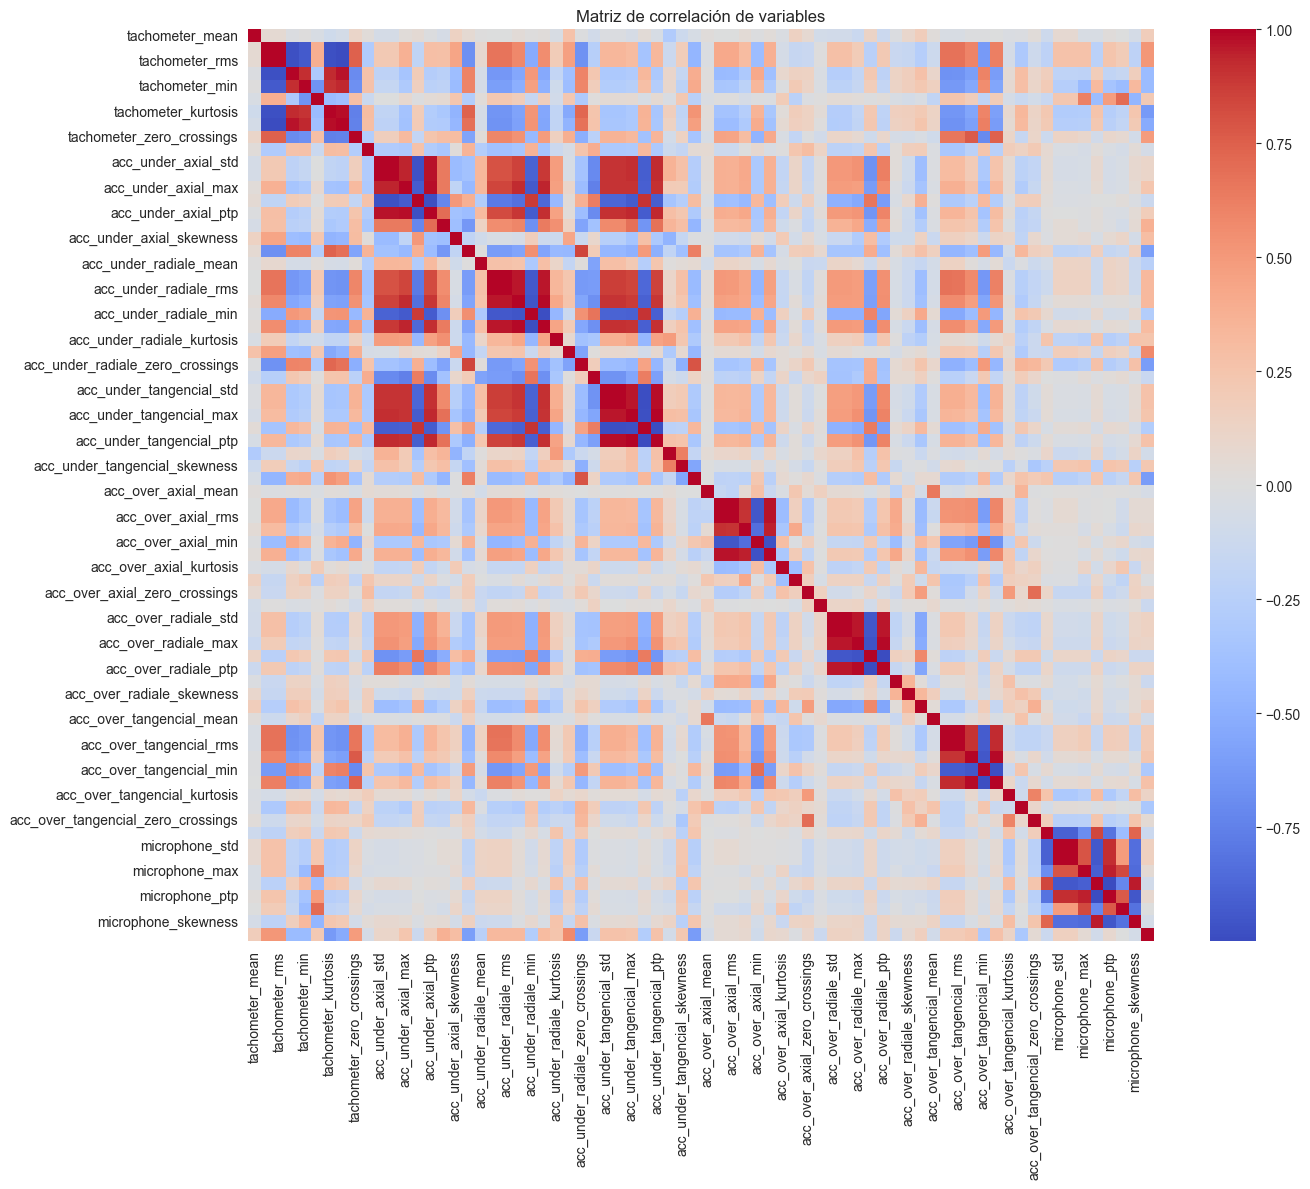

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0)
plt.title("Matriz de correlación de variables")
plt.tight_layout()
plt.show()


Random Forest

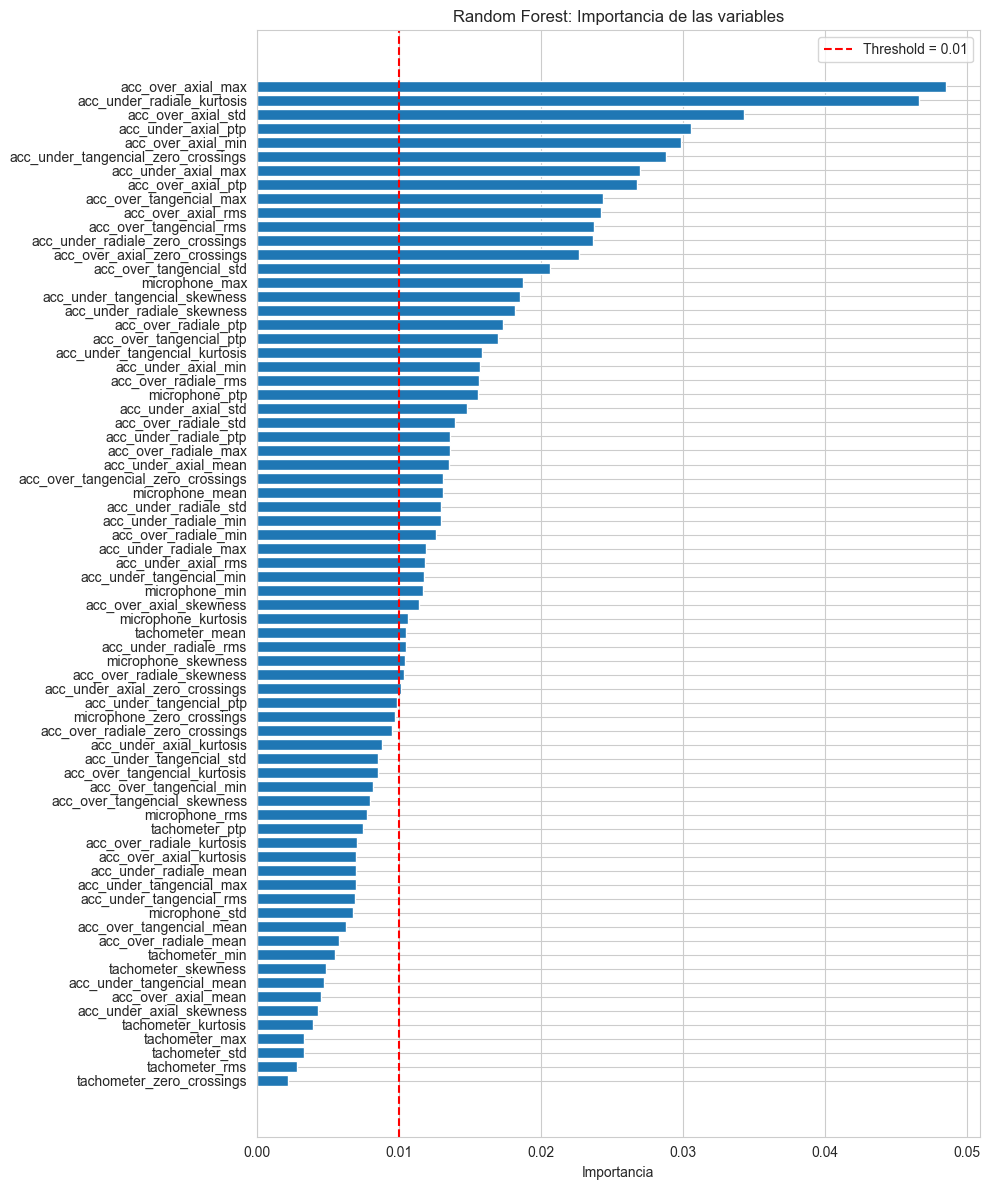

In [36]:
# =========================
# IMPORTS
# =========================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import kurtosis, skew
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# =========================
# CONFIGURACIÓN
# =========================
BASE_PATH = "../bearing_fault_detection_reduced"
THRESHOLD = 0.01
RANDOM_STATE = 42

SENSOR_NAMES = [
    "tachometer",
    "acc_under_axial",
    "acc_under_radiale",
    "acc_under_tangencial",
    "acc_over_axial",
    "acc_over_radiale",
    "acc_over_tangencial",
    "microphone"
]

# =========================
# FEATURE EXTRACTION
# =========================
def extract_features(signal: np.ndarray) -> dict:
    return {
        "mean": np.mean(signal),
        "std": np.std(signal),
        "rms": np.sqrt(np.mean(signal**2)),
        "max": np.max(signal),
        "min": np.min(signal),
        "ptp": np.ptp(signal),
        "kurtosis": kurtosis(signal),
        "skewness": skew(signal),
        "zero_crossings": np.sum(np.diff(np.sign(signal)) != 0),
    }

# =========================
# PROCESAR CSV
# =========================
def process_csv(csv_path: str) -> dict:
    df = pd.read_csv(csv_path, header=None)
    row = {}

    for i, sensor in enumerate(SENSOR_NAMES):
        signal = df.iloc[:, i].values
        feats = extract_features(signal)

        for fname, fval in feats.items():
            row[f"{sensor}_{fname}"] = fval

    return row

# =========================
# CONSTRUIR DATASET
# =========================
def build_dataset(base_path: str) -> pd.DataFrame:
    rows = []

    for root, _, files in os.walk(base_path):
        for file in files:
            if file.endswith(".csv"):
                path = os.path.join(root, file)

                row = process_csv(path)

                # label = carpeta principal
                label = os.path.relpath(root, base_path).split(os.sep)[0]
                row["label"] = label

                rows.append(row)

    return pd.DataFrame(rows)

# =========================
# MAIN
# =========================
df = build_dataset(BASE_PATH)

# X / y
X = df.drop(columns="label")
y = df["label"]

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, stratify=y_enc, random_state=RANDOM_STATE
)

# =========================
# RANDOM FOREST
# =========================
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    class_weight="balanced"
)

rf.fit(X_train, y_train)

# =========================
# FEATURE IMPORTANCE
# =========================
importance_df = pd.DataFrame({
    "feature": X.columns,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

# =========================
# PLOT
# =========================
plt.figure(figsize=(10, 12))

plt.barh(
    importance_df["feature"],
    importance_df["importance"]
)

plt.axvline(
    x=THRESHOLD,
    color="red",
    linestyle="--",
    label="Threshold = 0.01"
)

plt.gca().invert_yaxis()
plt.xlabel("Importancia")
plt.title("Random Forest: Importancia de las variables")
plt.legend()
plt.tight_layout()
plt.show()

In [43]:
TOP_N = 40
top_40_features = importance_df.head(TOP_N)
print(top_40_features[["feature", "importance"]])


                                feature  importance
39                   acc_over_axial_max    0.048524
24           acc_under_radiale_kurtosis    0.046672
37                   acc_over_axial_std    0.034324
14                  acc_under_axial_ptp    0.030561
40                   acc_over_axial_min    0.029898
35  acc_under_tangencial_zero_crossings    0.028851
12                  acc_under_axial_max    0.026995
41                   acc_over_axial_ptp    0.026792
57              acc_over_tangencial_max    0.024406
38                   acc_over_axial_rms    0.024270
56              acc_over_tangencial_rms    0.023734
26     acc_under_radiale_zero_crossings    0.023709
44        acc_over_axial_zero_crossings    0.022691
55              acc_over_tangencial_std    0.020633
66                       microphone_max    0.018750
34        acc_under_tangencial_skewness    0.018528
25           acc_under_radiale_skewness    0.018174
50                 acc_over_radiale_ptp    0.017344
59          